# Denoising Convolutional Autoencoders
### In this experiment, we will train a denoising autoencoder (input noisy image, output noise-reduced image) and perform unlabeled training / testing on it using MNIST dataset that we load thru Keras. Be sure to have tensorflow / keras installed before moving on.
### We will from time to time refer to the blog tutorial at https://blog.keras.io/building-autoencoders-in-keras.html as general guidance.
### Let us begin by downloading the MNIST dataset.

In [1]:
# If you have Anaconda Ipython installed, easily install Keras and Tensorflow by typing the following in the command line:
# conda install -c conda-forge tensorflow 
# conda install -c conda-forge keras
# You may also search for Keras and Tensorflow at https://anaconda.org/ for updated instructions if needed.
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np

# Since we're doing unlabeled training, we don't need y_train or y_test
(x_train, _), (x_test, _) = mnist.load_data()

# The x_train data is a 60000 x 28 x 28 3D matrix where each element takes on value 0 thru 255 (60,000 train images)
# The x_test data is 10000 x 28 x 28 (10,000 test images)
print(x_train.shape)
print(x_test.shape)

# print(x_train[0])
# print(type(x_test))

Using TensorFlow backend.


(60000, 28, 28)
(10000, 28, 28)


### For each image in the training set, we'll generate two images where the probability of a pixel being flipped is 3%. The new training set size should be 120k images.
### First we will double the size of the training data.

In [2]:
# We want to make the training data twice as long
x_train = np.concatenate((x_train, x_train), axis = 0)
# print(x_train.shape)
# print(x_train[0])

### Next we will randomly flip pixels with 3% probability for the training data.

In [3]:
import random
# For each image in training set of 60,000 images, we will randomly "flip" pixels with probability 3%, and
# generate two images this way. This will result in new training data size of 120,000 images.

def flip(image, x, y):
    image[x][y] = 255 - image[x][y]

def addRandomNoise(image):
    for i in range(len(image)):
        for j in range(len(image[i])):
            if random.random() <= 0.03:
                flip(image, i, j)

x_train_noise = x_train.copy()  # Initialize training data that'll hold 120,000 images, 28x28 each

for i in range(len(x_train_noise)):
    addRandomNoise(x_train_noise[i])
    if i % 5000 == 0:
        print("Iteration {}...".format(i))
print("Done adding noise to training data.")

Iteration 0...
Iteration 5000...
Iteration 10000...
Iteration 15000...
Iteration 20000...
Iteration 25000...
Iteration 30000...
Iteration 35000...
Iteration 40000...
Iteration 45000...
Iteration 50000...
Iteration 55000...
Iteration 60000...
Iteration 65000...
Iteration 70000...
Iteration 75000...
Iteration 80000...
Iteration 85000...
Iteration 90000...
Iteration 95000...
Iteration 100000...
Iteration 105000...
Iteration 110000...
Iteration 115000...
Done adding noise to training data.


### We will also add noise to the testing data.

In [4]:
# For each image in testing set, we'll generate one (not two) noisy image in the same manner as above.
# This will be used later as test input for checking the performance of our denoising autoencoder

x_test_noise = x_test.copy()
for i in range(len(x_test_noise)): # 60,000 images = 60,000 iterations
    if i % 1000 == 0:
        print("Iteration {}...".format(i))
    addRandomNoise(x_test_noise[i])
print("Done adding noise to test data.")

Iteration 0...
Iteration 1000...
Iteration 2000...
Iteration 3000...
Iteration 4000...
Iteration 5000...
Iteration 6000...
Iteration 7000...
Iteration 8000...
Iteration 9000...
Done adding noise to test data.



### Next we normalize all the data.

In [5]:
# normalize training / testing data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

x_train_noise = x_train_noise.astype('float32') / 255.
x_test_noise = x_test_noise.astype('float32') / 255.
x_train_noise = np.reshape(x_train_noise, (len(x_train_noise), 28, 28, 1)) # adapt this if using `channels_first` image data format
x_test_noise = np.reshape(x_test_noise, (len(x_test_noise), 28, 28, 1))  # adapt this if using `channels_first` image data format

print("Shapes of the training and testing data:")
print(x_train.shape)
print(x_test.shape)

Shapes of the training and testing data:
(120000, 28, 28, 1)
(10000, 28, 28, 1)


### Here is an example of the data with noise added in.

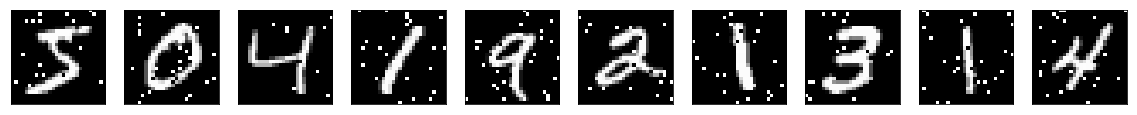

In [6]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noise[i].reshape(28, 28))
#     plt.imshow(x_train_noise[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Now we will implement a convolutional autoencoder four times by varying the CNN architecture in four ways.
### To this end, we will implement two functions that employ different architectures, and we will also try varying activation parameters as shown below.

In [7]:
def apply_filters(input_img, activation1, activation2):
    x = Conv2D(32, (3, 3), activation=activation1, padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation=activation1, padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation=activation1, padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation=activation1, padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation=activation2, padding='same')(x)
    
    return decoded

In [8]:
def apply_filters2(input_img, activation1, activation2):

    x = Conv2D(16, (3, 3), activation=activation1, padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation=activation1, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation=activation1, padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (3, 3), activation=activation1, padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation=activation1, padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation=activation1)(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation=activation2, padding='same')(x)
    
    return decoded

### We will try out a number of different activation functions as shown below, and will invoke one of the two methods above for greater variety. The result is 4 different CNN architectures.

In [9]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
decoded1 = apply_filters(input_img, 'relu', 'sigmoid')
decoded2 = apply_filters2(input_img, 'relu', 'tanh')
decoded3 = apply_filters(input_img, 'linear', 'relu')
decoded4 = apply_filters2(input_img, 'linear', 'sigmoid')

In [10]:
autoencoder1 = Model(input_img, decoded1)
autoencoder1.compile(optimizer='adadelta', metrics=['mse','accuracy'], loss= 'binary_crossentropy')

autoencoder2 = Model(input_img, decoded2)
autoencoder2.compile(optimizer='adadelta', metrics=['mse','accuracy'], loss = 'binary_crossentropy')

autoencoder3 = Model(input_img, decoded3)
autoencoder3.compile(optimizer='adadelta', metrics=['mse','accuracy'], loss = 'binary_crossentropy')

autoencoder4 = Model(input_img, decoded4)
autoencoder4.compile(optimizer='adadelta', metrics=['mse','accuracy'], loss = 'binary_crossentropy')

### We will now write a function that invokes the .fit() method as shown below. We use epochs=20 due to time efficiency constraints. We will save a history of each of the 4 autoencoders' results in history_list for later plotting.

In [20]:
from keras.callbacks import TensorBoard

history_list = []

def auto_fit(history_list, encoder):
    history = encoder.fit(x_train_noise, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noise, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
    history_list.append(history)

In [21]:
auto_fit(history_list, autoencoder1)

Train on 120000 samples, validate on 10000 samples
Epoch 1/20
120000/120000 [==============================] - 555s - loss: 0.1031 - mean_squared_error: 0.0135 - acc: 0.8121 - val_loss: 0.0807 - val_mean_squared_error: 0.0063 - val_acc: 0.8140
Epoch 2/20
120000/120000 [==============================] - 629s - loss: 0.0783 - mean_squared_error: 0.0056 - acc: 0.8149 - val_loss: 0.0752 - val_mean_squared_error: 0.0048 - val_acc: 0.8140
Epoch 3/20
120000/120000 [==============================] - 694s - loss: 0.0752 - mean_squared_error: 0.0046 - acc: 0.8151 - val_loss: 0.0745 - val_mean_squared_error: 0.0046 - val_acc: 0.8141
Epoch 4/20
120000/120000 [==============================] - 660s - loss: 0.0738 - mean_squared_error: 0.0042 - acc: 0.8152 - val_loss: 0.0728 - val_mean_squared_error: 0.0039 - val_acc: 0.8143
Epoch 5/20
120000/120000 [==============================] - 629s - loss: 0.0727 - mean_squared_error: 0.0039 - acc: 0.8152 - val_loss: 0.0720 - val_mean_squared_error: 0.0037 - 

In [22]:
auto_fit(history_list, autoencoder2)

Train on 120000 samples, validate on 10000 samples
Epoch 1/20
120000/120000 [==============================] - 209s - loss: 0.2266 - mean_squared_error: 0.1179 - acc: 0.7185 - val_loss: 0.1950 - val_mean_squared_error: 0.1634 - val_acc: 0.5993
Epoch 2/20
120000/120000 [==============================] - 208s - loss: 0.1875 - mean_squared_error: 0.2130 - acc: 0.4821 - val_loss: 0.1800 - val_mean_squared_error: 0.2582 - val_acc: 0.3981
Epoch 3/20
120000/120000 [==============================] - 207s - loss: 0.1767 - mean_squared_error: 0.2966 - acc: 0.3540 - val_loss: 0.1712 - val_mean_squared_error: 0.3303 - val_acc: 0.3180
Epoch 4/20
120000/120000 [==============================] - 208s - loss: 0.1710 - mean_squared_error: 0.3573 - acc: 0.2998 - val_loss: 0.1665 - val_mean_squared_error: 0.3855 - val_acc: 0.2725
Epoch 5/20
120000/120000 [==============================] - 206s - loss: 0.1664 - mean_squared_error: 0.3963 - acc: 0.2688 - val_loss: 0.1628 - val_mean_squared_error: 0.4258 - 

In [37]:
auto_fit(history_list, autoencoder3)

Train on 120000 samples, validate on 10000 samples
Epoch 1/20
120000/120000 [==============================] - 874s - loss: 0.1202 - mean_squared_error: 0.0172 - acc: 0.8132 - val_loss: 0.1009 - val_mean_squared_error: 0.0114 - val_acc: 0.8135
Epoch 2/20
120000/120000 [==============================] - 11176s - loss: 0.0995 - mean_squared_error: 0.0108 - acc: 0.8145 - val_loss: 0.0946 - val_mean_squared_error: 0.0093 - val_acc: 0.8138
Epoch 3/20
120000/120000 [==============================] - 848s - loss: 0.0951 - mean_squared_error: 0.0093 - acc: 0.8147 - val_loss: 0.0923 - val_mean_squared_error: 0.0086 - val_acc: 0.8139
Epoch 4/20
120000/120000 [==============================] - 775s - loss: 0.0934 - mean_squared_error: 0.0088 - acc: 0.8148 - val_loss: 0.0909 - val_mean_squared_error: 0.0082 - val_acc: 0.8139
Epoch 5/20
120000/120000 [==============================] - 781s - loss: 0.0918 - mean_squared_error: 0.0083 - acc: 0.8149 - val_loss: 0.0946 - val_mean_squared_error: 0.0092 

In [24]:
auto_fit(history_list, autoencoder4)

Train on 120000 samples, validate on 10000 samples
Epoch 1/20
120000/120000 [==============================] - 203s - loss: 0.2002 - mean_squared_error: 0.0454 - acc: 0.7980 - val_loss: 0.1635 - val_mean_squared_error: 0.0340 - val_acc: 0.8031
Epoch 2/20
120000/120000 [==============================] - 200s - loss: 0.1573 - mean_squared_error: 0.0318 - acc: 0.8040 - val_loss: 0.1480 - val_mean_squared_error: 0.0285 - val_acc: 0.8027
Epoch 3/20
120000/120000 [==============================] - 202s - loss: 0.1445 - mean_squared_error: 0.0274 - acc: 0.8064 - val_loss: 0.1368 - val_mean_squared_error: 0.0248 - val_acc: 0.8067
Epoch 4/20
120000/120000 [==============================] - 203s - loss: 0.1359 - mean_squared_error: 0.0245 - acc: 0.8079 - val_loss: 0.1301 - val_mean_squared_error: 0.0226 - val_acc: 0.8082
Epoch 5/20
120000/120000 [==============================] - 202s - loss: 0.1300 - mean_squared_error: 0.0225 - acc: 0.8089 - val_loss: 0.1273 - val_mean_squared_error: 0.0218 - 

### Now we will plot the results of the 4 autoencoders' MSE as a function of the number of epochs.

In [25]:
def plot_history(history):
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('Mean Squared Error')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### The results are plotted below from autoencoder1 thru autoencoder4.

[<keras.callbacks.History object at 0x00000193A2BBD3C8>, <keras.callbacks.History object at 0x00000193A330BBE0>, <keras.callbacks.History object at 0x00000193A38E8C18>, <keras.callbacks.History object at 0x00000193A4003F98>, <keras.callbacks.History object at 0x00000193A7818A58>]


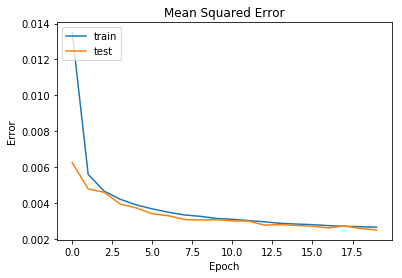

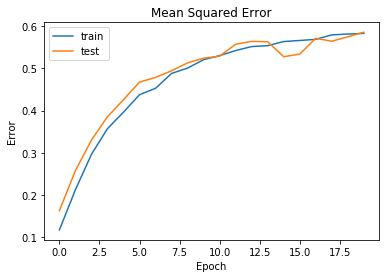

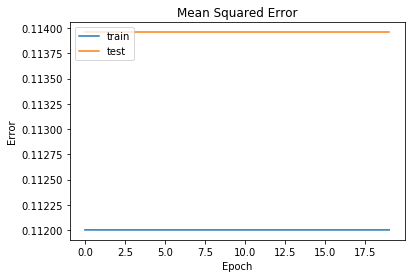

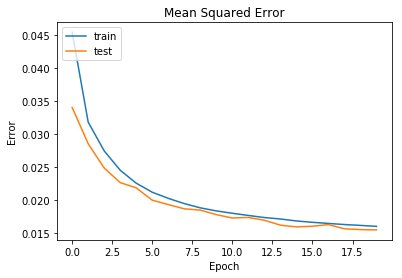

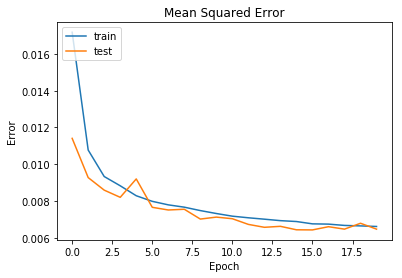

In [44]:
print (history_list)
for history in history_list:
    plot_history(history)

### Now we will use each of these 4 autoencoders to make predictions on the noisy test data set and output the denoised images.

In [39]:
decoded_imgs1 = autoencoder1.predict(x_test_noise)
decoded_imgs2 = autoencoder2.predict(x_test_noise)
decoded_imgs3 = autoencoder3.predict(x_test_noise)
decoded_imgs4 = autoencoder4.predict(x_test_noise)

### We will write a function to measure the mean squared error between the predicted denoised images and the actual (correct) images without noise. We will then get the top 10 best and worst images for each autoencoder.

In [40]:
def mse(imageA, imageB):
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [41]:
mse_1 = []
mse_2 = []
mse_3 = []
mse_4 = []

# populate list of mse's for each autoencoder
for i in range(len(x_test)):
    err1 = mse(decoded_imgs1[i], x_test[i])
    err2 = mse(decoded_imgs2[i], x_test[i])
    err3 = mse(decoded_imgs3[i], x_test[i])
    err4 = mse(decoded_imgs4[i], x_test[i])
    mse_1.append((err1, i))
    mse_2.append((err2, i))
    mse_3.append((err3, i))
    mse_4.append((err4, i))

# Sort each list. Afterwards we'll get the top and bottom 10 for each.
mse_1.sort()
mse_2.sort()
mse_3.sort()
mse_4.sort()

# checking to verify top 10 and bottom 10
print(mse_1[:10], mse_1[-10:])
print(mse_2[:10], mse_2[-10:])
print(mse_3[:10], mse_3[-10:])
print(mse_4[:10], mse_4[-10:])

[(0.22021765507745725, 3364), (0.2228767649531733, 3727), (0.22344779571902304, 8330), (0.22404728948674735, 6580), (0.22433994815592789, 9742), (0.22473971186630939, 1415), (0.22491428002232991, 2107), (0.22491477390741937, 8140), (0.22498470335635198, 1438), (0.22503475593306099, 7545)] [(0.25124036877105649, 3741), (0.25139658548616434, 8586), (0.25143241314144926, 1897), (0.25147420612816901, 279), (0.25195215644432567, 9282), (0.25209108369743483, 1835), (0.25217110081053556, 1038), (0.25281217451201249, 5553), (0.25291315415695337, 1657), (0.2555588714330061, 9051)]
[(0.01987036601094368, 6572), (0.021434480729884076, 2532), (0.021506732228154458, 2867), (0.021881233097653732, 2245), (0.023929811205754211, 2689), (0.024518018035682754, 3196), (0.024624822158709134, 3851), (0.025331437463159818, 4719), (0.02533577972887615, 224), (0.025816573722645661, 3039)] [(0.20216397685398133, 7919), (0.20237117778005684, 7845), (0.20255408283695822, 2649), (0.2032472443009713, 7904), (0.2039

In [42]:
# Top 10 and Bottom 10 images for each autoencoder (1-4) in terms of MSE
best_10_1 = mse_1[:10]
best_10_2 = mse_2[:10]
best_10_3 = mse_3[:10]
best_10_4 = mse_4[:10]

#reversing the bottom 10 results in list ordered from the #1 worst to the #10 worst
worst_10_1 = list(reversed(mse_1[-10:]))
worst_10_2 = list(reversed(mse_2[-10:]))
worst_10_3 = list(reversed(mse_3[-10:]))
worst_10_4 = list(reversed(mse_4[-10:]))

#testing
# print(best_10_3)
# print(worst_10_3)

def plot_images(top_10, imgs):
    n = len(top_10)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        tup = top_10[i]
        img_index = tup[1]
#         print("img_index:", img_index)
        plt.imshow(imgs[img_index].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

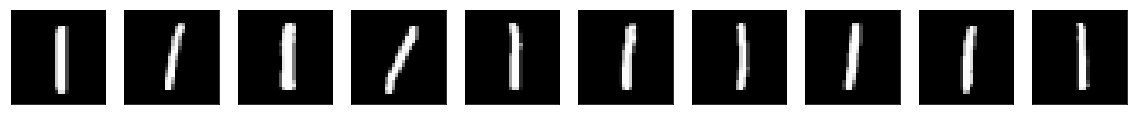

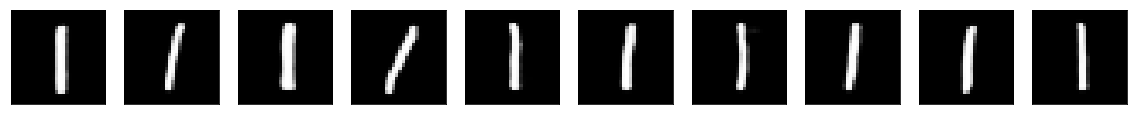

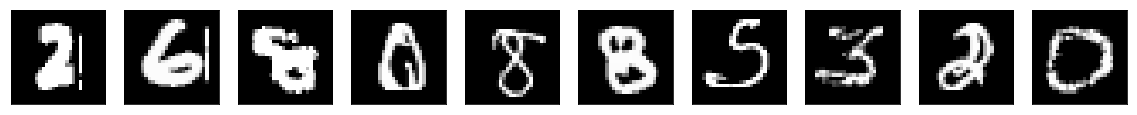

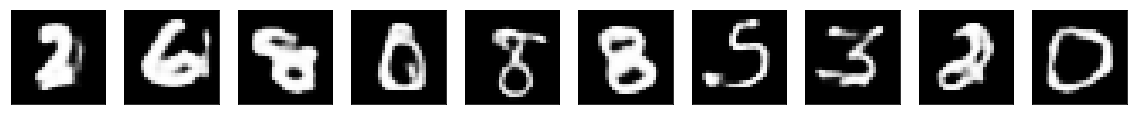

In [31]:
plot_images(best_10_1, x_test)
plot_images(best_10_1, decoded_imgs1)
plot_images(worst_10_1, x_test)
plot_images(worst_10_1, decoded_imgs1)

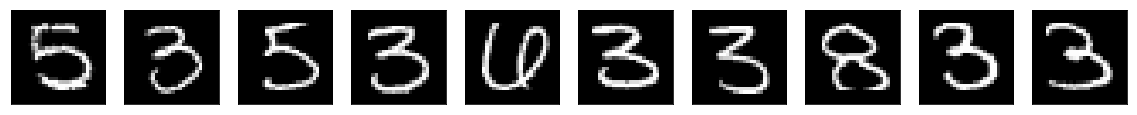

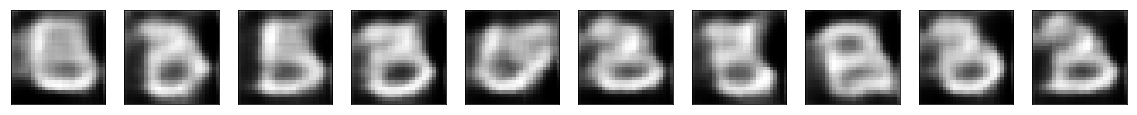

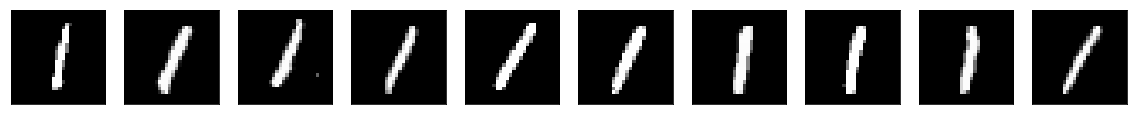

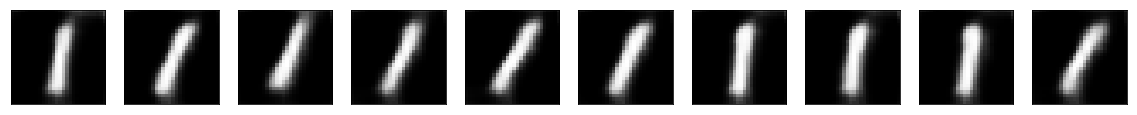

In [32]:
plot_images(best_10_2, x_test)
plot_images(best_10_2, decoded_imgs2)
plot_images(worst_10_2, x_test)
plot_images(worst_10_2, decoded_imgs2)

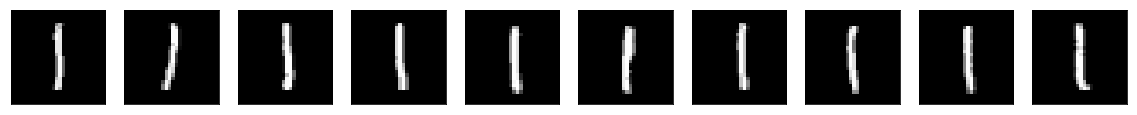

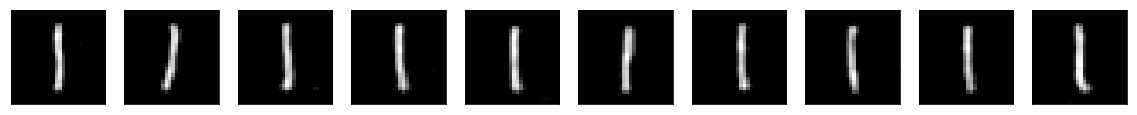

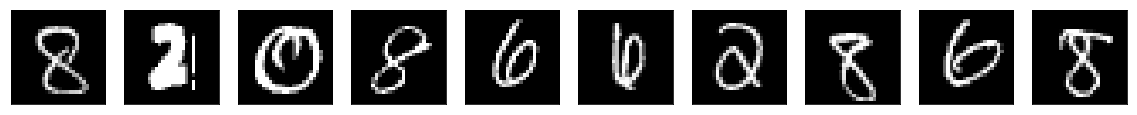

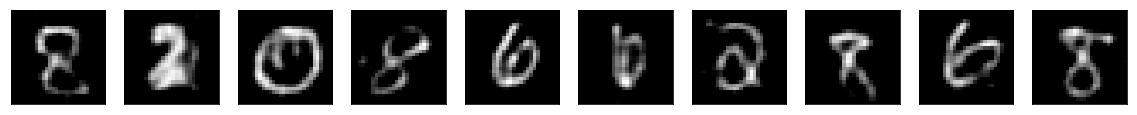

In [45]:
plot_images(best_10_3, x_test)
plot_images(best_10_3, decoded_imgs3)
plot_images(worst_10_3, x_test)
plot_images(worst_10_3, decoded_imgs3)

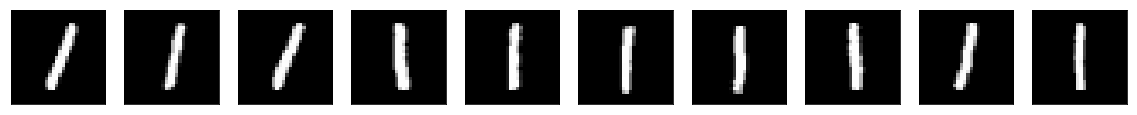

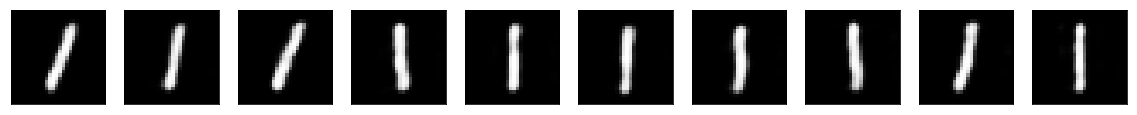

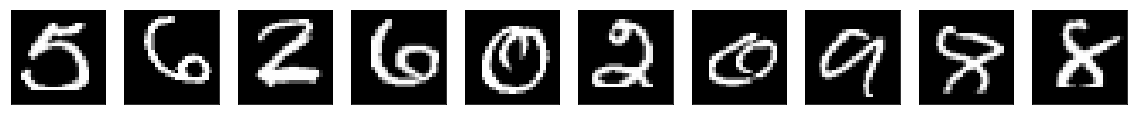

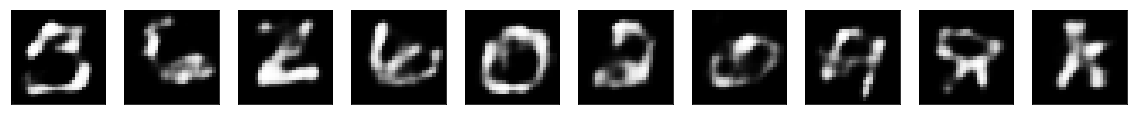

In [34]:
plot_images(best_10_4, x_test)
plot_images(best_10_4, decoded_imgs4)
plot_images(worst_10_4, x_test)
plot_images(worst_10_4, decoded_imgs4)

### We can see that the best images seem to pertain to the most straightforward and easiest digits, such as the digit 1, whereas the worst images in general have to do with more complex shapes, such as 8. The type of architecture and activations used also have a significant impact on the quality of the predictions; for instance, as we can see autoencoder1's predicted images look much sharper in general, whereas autoencoder2's images are nigh indistinguishable from one another.